<a href="https://colab.research.google.com/github/FERNANDOBUCHELLY/TAM2025-2/blob/main/Copia_de_7_ConglomeradosNosupervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje no supervisado

In [ ]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np

data = load_iris()
X    = data.data
y    = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
# Ejecuta esta celda para detectar si tienes cuML disponible y para mostrar info.
try:
    import cuml
    import cupy as cp
    rapids_available = True
    print("RAPIDS/cuML detectado. El notebook usará cuML (GPU) cuando sea posible.")
except Exception as e:
    rapids_available = False
    print("RAPIDS/cuML NO detectado. El notebook usará scikit-learn (CPU) como fallback.")
    print("Mensaje de error (si relevante):", e)

# Imprime versión de python y paquetes básicos
import sys
print("Python:", sys.version.splitlines()[0])

RAPIDS/cuML detectado. El notebook usará cuML (GPU) cuando sea posible.
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
# ============================
# PARTE 2: IMPORTS Y AUXILIARES
# ============================
# Aquí importamos librerías y definimos funciones que usaremos más adelante.
# Comentarios explicativos incluidos.

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as SKKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN as SKDBSCAN
from time import time
import pandas as pd

# Si rapids está disponible, importamos sus clases dentro de try para no caer si no existe.
if rapids_available:
    try:
        from cuml.cluster import KMeans as cuKMeans
        from cuml.cluster import DBSCAN as cuDBSCAN
        # Nota: cuML puede tener otras implementaciones; usaré KMeans y DBSCAN si están.
    except Exception as e:
        print("Error importando clases de cuML:", e)
        rapids_available = False


# ---------- Parámetros generales ----------
MAX_DIM = 126   # redimensionar imagen grande para acelerar (puedes ajustar)
SILHOUETTE_SAMPLE = 2000  # número máximo de píxeles para calcular silhouette (muestreo aleatorio)
SEED = 42

# ---------- Funciones auxiliares ----------
def load_and_resize_image(url_or_path, max_dim=MAX_DIM):
    """Carga una imagen (URL o path) y la redimensiona manteniendo relación de aspecto
       para que el lado mayor sea max_dim (si es mayor). Devuelve imagen en uint8."""
    img = io.imread(url_or_path)
    if img.dtype != np.uint8:
        # convertir escalas si hace falta
        img = (255 * (img / np.max(img))).astype(np.uint8)
    h, w = img.shape[:2]
    scale = 1.0
    if max(h, w) > max_dim:
        scale = max_dim / max(h, w)
        img = transform.rescale(img, scale, channel_axis=-1, anti_aliasing=True)

        img = (255 * img).astype(np.uint8)
    return img, scale

def prepare_pixel_features(img, include_position=True):
    """Convierte una imagen HxWx3 en matriz Nx(d) con características:
       - RGB normalizado [0,1]
       - opcionalmente coordenadas x,y normalizadas [0,1]
       Devuelve X (float32) y la forma original (h,w)."""
    h, w = img.shape[:2]
    X_rgb = img.reshape(-1, 3).astype(np.float32) / 255.0
    if include_position:
        xs, ys = np.meshgrid(np.arange(w), np.arange(h))
        pos = np.stack([xs.ravel() / w, ys.ravel() / h], axis=1).astype(np.float32)
        X = np.concatenate([X_rgb, pos], axis=1)
    else:
        X = X_rgb
    return X, (h, w)

def visualize_segmentation(labels, shape, title=None, palette=None):
    """Dibuja la segmentación (labels: N) en una imagen de tamaño shape=(h,w).
       Cada cluster tendrá un color promedio o una paleta si se provee."""
    h, w = shape
    labels_img = labels.reshape(h, w)
    # mapear cada etiqueta a un color por su valor medio de RGB del cluster
    unique = np.unique(labels)
    out = np.zeros((h, w, 3), dtype=np.uint8)
    if palette is None:
        # paleta: colores generados aleatoriamente por número de clusters
        rng = np.random.RandomState(0)
        palette = {lab: (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)) for lab in unique}
    for lab, color in palette.items():
        out[labels_img == lab] = color
    plt.figure(figsize=(6,6))
    plt.imshow(out)
    plt.title(title or "Segmentación")
    plt.axis('off')
    plt.show()


Imagen cargada. Nuevo tamaño: (94, 126), escala aplicada: 0.486


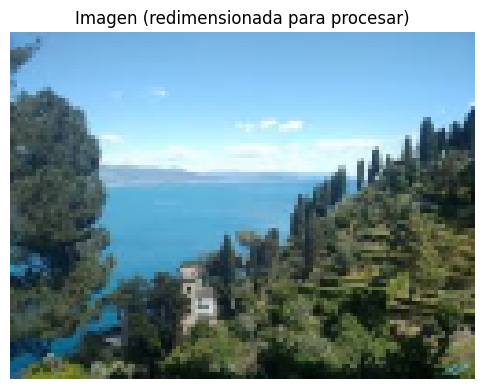

Muestras (píxeles) y características: (11844, 5)


In [ ]:
# ============================
# PARTE 3: CARGA Y PREPROCESAMIENTO
# ============================

# Cambia esta URL por la de tu imagen o sube tu imagen y pon la ruta local.
image_url = "/content/images (1).jfif"



# Cargar y redimensionar
img, scale = load_and_resize_image(image_url, max_dim=MAX_DIM)
print(f"Imagen cargada. Nuevo tamaño: {img.shape[:2]}, escala aplicada: {scale:.3f}")

# Mostrar imagen original redimensionada
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title("Imagen (redimensionada para procesar)")
plt.axis('off')
plt.show()

# Preparar características de píxeles: RGB + posición normalizada
X, shape_hw = prepare_pixel_features(img, include_position=True)
print("Muestras (píxeles) y características:", X.shape)



--- Ejecutando KMeans con k = 3 ---
k=3  tiempo_fit=0.01s  inertia=1682.0552978515625  silhouette=0.3880728483200073


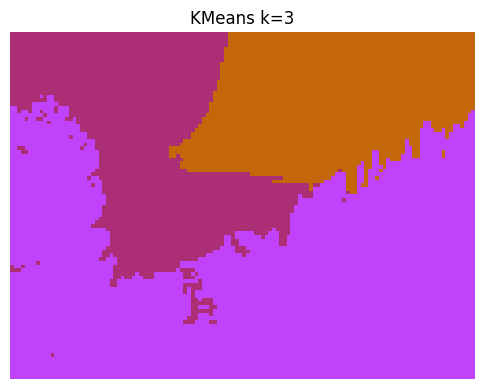


--- Ejecutando KMeans con k = 5 ---
k=5  tiempo_fit=0.01s  inertia=1010.71923828125  silhouette=0.362697035074234


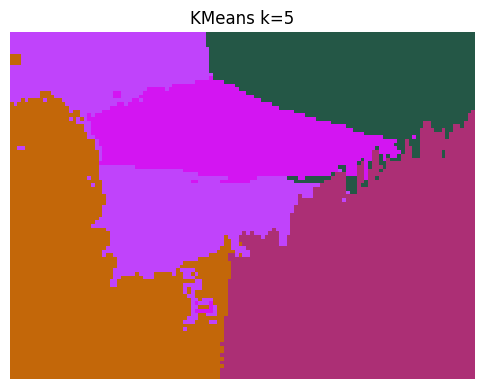


--- Ejecutando KMeans con k = 7 ---
k=7  tiempo_fit=0.01s  inertia=847.4739990234375  silhouette=0.3272590935230255


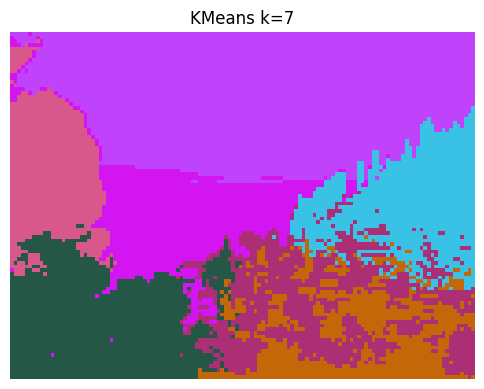


--- Ejecutando KMeans con k = 9 ---
k=9  tiempo_fit=0.01s  inertia=549.748291015625  silhouette=0.36947906017303467


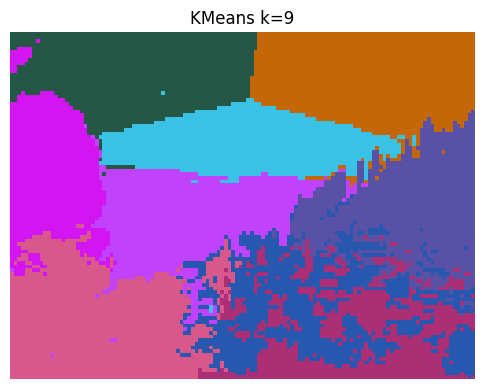

In [ ]:
# ============================
# PARTE 4: K-MEANS para k ∈ {3,5,7,9}
# ============================
k_values = [3, 5, 7, 9]
results = []

for k in k_values:
    print(f"\n--- Ejecutando KMeans con k = {k} ---")
    t0 = time()
    if rapids_available:
        # Usamos cuML (GPU) si está disponible
        try:
            kmeans = cuKMeans(n_clusters=k, random_state=SEED)
            # cuML espera inputs en cupy o cudf; cupy acepta numpy si se convierte:
            import cupy as cp
            X_gpu = cp.asarray(X)  # transferir a GPU
            kmeans.fit(X_gpu)
            labels_gpu = kmeans.predict(X_gpu)
            labels = cp.asnumpy(labels_gpu).astype(int)
            # cuML KMeans no siempre tiene 'inertia_' igual que sklearn; intentamos obtenerlo
            inertia = None
            if hasattr(kmeans, 'inertia_'):
                try:
                    inertia = float(kmeans.inertia_)
                except:
                    inertia = None
        except Exception as e:
            print("Error usando cuML KMeans, volcando a sklearn. Error:", e)
            rapids_available = False  # desactivar para futuras iteraciones
            # continuar al bloque de fallback (sklearn)
    if not rapids_available:
        # Fallback: scikit-learn (CPU)
        kmeans = SKKMeans(n_clusters=k, random_state=SEED, n_init=10)
        kmeans.fit(X)
        labels = kmeans.labels_.astype(int)
        inertia = float(kmeans.inertia_)
    t1 = time()

    # Calcular Silhouette (puede ser costoso -> muestreamos si es muy grande)
    n_samples = X.shape[0]
    if n_samples > SILHOUETTE_SAMPLE:
        rng = np.random.RandomState(SEED)
        sample_idx = rng.choice(n_samples, SILHOUETTE_SAMPLE, replace=False)
        X_sample = X[sample_idx]
        labels_sample = labels[sample_idx]
    else:
        X_sample = X
        labels_sample = labels

    # silhouette_score requiere al menos 2 clusters y etiquetas válidas
    sil_score = None
    try:
        sil_score = silhouette_score(X_sample, labels_sample, metric='euclidean')
    except Exception as e:
        print("No se pudo calcular silhouette:", e)
        sil_score = None

    elapsed = t1 - t0
    print(f"k={k}  tiempo_fit={elapsed:.2f}s  inertia={inertia}  silhouette={sil_score}")

    # Almacenar resultados
    results.append({'method': 'KMeans (cuML)' if rapids_available else 'KMeans (sklearn)',
                    'k': k,
                    'inertia': inertia,
                    'silhouette': sil_score,
                    'time_s': elapsed,
                    'labels': labels.copy()})

    # Visualizar segmentación coloreada por cluster
    visualize_segmentation(results[-1]['labels'], shape_hw, title=f"KMeans k={k}")



Agglomerative k=3
  tiempo=3.95s  silhouette=0.3168


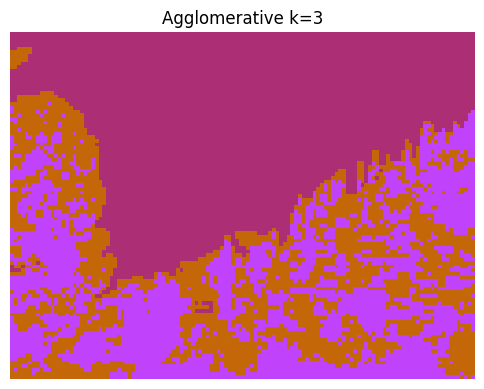


Agglomerative k=5
  tiempo=3.33s  silhouette=0.1400


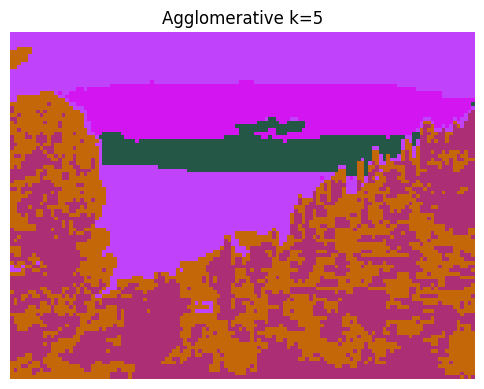


Agglomerative k=7
  tiempo=3.34s  silhouette=0.1276


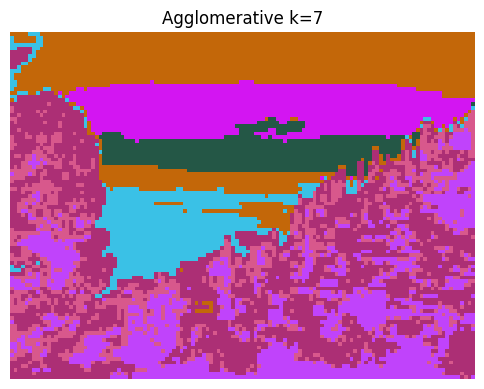


DBSCAN (sklearn) — ejemplo con eps=0.02 (en espacio RGB normalizado)
DBSCAN encontrado 29 clusters (eps=0.02)  tiempo=0.12s


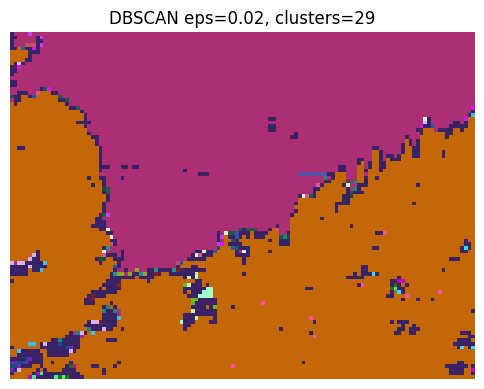

In [ ]:
# ============================
# PARTE 5: DBSCAN y Agglomerative (comparación)
# ============================
# Reducimos características a RGB solo (sin posiciones) para estos ejemplos (ajustable).
X_rgb_only = X[:, :3]  # si quieres incluir posiciones, usa X en su totalidad

# 5.1 Agglomerative (jerárquico) — requerirá especificar número de clusters k
for k in [3, 5, 7]:
    print(f"\nAgglomerative k={k}")
    t0 = time()
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_rgb_only).astype(int)
    t1 = time()
    # silhouette (muestreado)
    n_samples = X.shape[0]
    if n_samples > SILHOUETTE_SAMPLE:
        rng = np.random.RandomState(SEED)
        idx = rng.choice(n_samples, SILHOUETTE_SAMPLE, replace=False)
        sil = silhouette_score(X[idx], labels[idx])
    else:
        sil = silhouette_score(X, labels)
    print(f"  tiempo={t1-t0:.2f}s  silhouette={sil:.4f}")
    visualize_segmentation(labels, shape_hw, title=f"Agglomerative k={k}")
    results.append({'method': 'Agglomerative', 'k': k, 'inertia': None, 'silhouette': sil, 'time_s': t1-t0, 'labels': labels.copy()})

# 5.2 DBSCAN (requiere elegir eps y min_samples)
print("\nDBSCAN (sklearn) — ejemplo con eps=0.02 (en espacio RGB normalizado)")
eps = 0.02
min_samples = 5
t0 = time()
db = SKDBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
labels = db.fit_predict(X_rgb_only).astype(int)
t1 = time()
# En DBSCAN, label -1 = ruido
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"DBSCAN encontrado {n_clusters} clusters (eps={eps})  tiempo={t1-t0:.2f}s")
# silhouette: no se puede calcular si solo 1 cluster; evitamos incluir ruido (-1)
if n_clusters > 1:
    mask = labels != -1
    try:
        sil = silhouette_score(X_rgb_only[mask], labels[mask])
    except Exception as e:
        sil = None
else:
    sil = None
visualize_segmentation(np.where(labels==-1, max(labels)+1, labels), shape_hw, title=f"DBSCAN eps={eps}, clusters={n_clusters}")
results.append({'method': 'DBSCAN', 'k': n_clusters, 'inertia': None, 'silhouette': sil, 'time_s': t1-t0, 'labels': labels.copy()})


In [ ]:
# ============================
# PARTE 6: TABLA DE RESULTADOS
# ============================
df = pd.DataFrame([{'method': r['method'], 'k': r['k'], 'inertia': r.get('inertia'), 'silhouette': r.get('silhouette'), 'time_s': r['time_s']} for r in results])
display(df.sort_values(['method','k']).reset_index(drop=True))

,method,k,inertia,silhouette,time_s
0,Agglomerative,3,NaN,0.316825,3.947186
1,Agglomerative,5,NaN,0.140008,3.334489
2,Agglomerative,7,NaN,0.127644,3.341562
3,DBSCAN,29,NaN,-0.267367,0.122417
4,KMeans (cuML),3,1682.055298,0.388073,0.012569
5,KMeans (cuML),5,1010.719238,0.362697,0.012437
6,KMeans (cuML),7,847.473999,0.327259,0.013134
7,KMeans (cuML),9,549.748291,0.369479,0.011363


In [ ]:
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
import math

In [ ]:
# ============================
# PARTE B: FUNCIONES AUXILIARES
# ============================
def compute_pca_2d(X, n_components=2, random_state=SEED):
    """PCA a 2D (rápido y determinista)."""
    pca = PCA(n_components=n_components, random_state=random_state)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

def compute_umap_2d(X, n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1):
    """UMAP a 2D. Ajusta n_neighbors/min_dist si quieres más/menos preservación local."""
    reducer = umap.UMAP(n_components=n_components, random_state=random_state,
                        n_neighbors=n_neighbors, min_dist=min_dist)
    X_umap = reducer.fit_transform(X)
    return X_umap, reducer

def plot_2d_scatter(X2, labels=None, title=None, point_size=4, cmap='tab20'):
    """Scatter 2D; si hay labels colorea por cluster, si no por densidad."""
    plt.figure(figsize=(6,6))
    if labels is None:
        plt.scatter(X2[:,0], X2[:,1], s=point_size, alpha=0.6)
    else:
        n_clusters = len(np.unique(labels))
        palette = cm.get_cmap(cmap, max(1,n_clusters))
        for i, lab in enumerate(np.unique(labels)):
            mask = labels == lab
            plt.scatter(X2[mask,0], X2[mask,1], s=point_size, color=palette(i), label=str(lab), alpha=0.7)
        plt.legend(loc='best', markerscale=2, fontsize='small', ncol=2)
    plt.title(title or "")
    plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

def labels_to_segmentation_and_show(labels, shape_hw, title=None):
    """Reconstruye la segmentación (labels por píxel) y la muestra usando visualize_segmentation()."""
    # labels debe tener N = h*w elementos
    visualize_segmentation(labels, shape_hw, title=title)


Shape original X: (11844, 5)
PCA completado. Forma: (11844, 2)


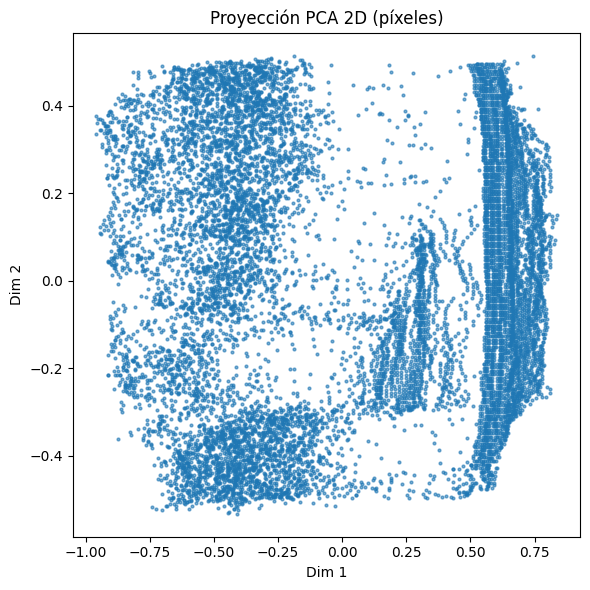

In [ ]:
# ============================
# PARTE C: PCA 2D (proyección)
# ============================
# Asume que X ya existe (p. ej. RGB + posiciones) y shape_hw también.
print("Shape original X:", X.shape)

# Ejecutar PCA
X_pca, pca_model = compute_pca_2d(X, n_components=2, random_state=SEED)
print("PCA completado. Forma:", X_pca.shape)

# Visualizar la proyección 2D
plot_2d_scatter(X_pca, labels=None, title="Proyección PCA 2D (píxeles)")



PCA -> MiniBatchKMeans k=3
  silhouette (muestra) = 0.5455751419067383


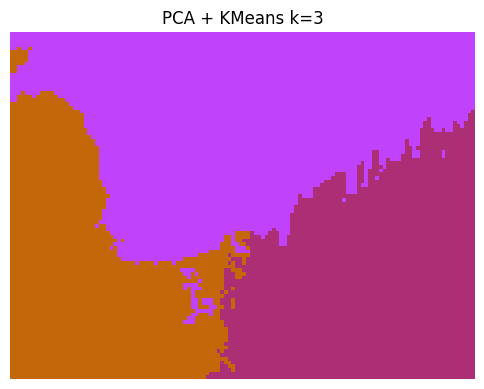


PCA -> MiniBatchKMeans k=5
  silhouette (muestra) = 0.42410993576049805


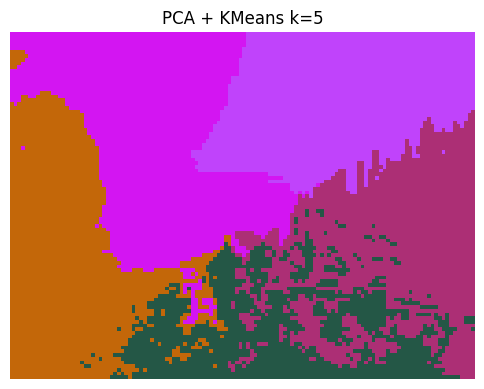


PCA -> MiniBatchKMeans k=7
  silhouette (muestra) = 0.43925780057907104


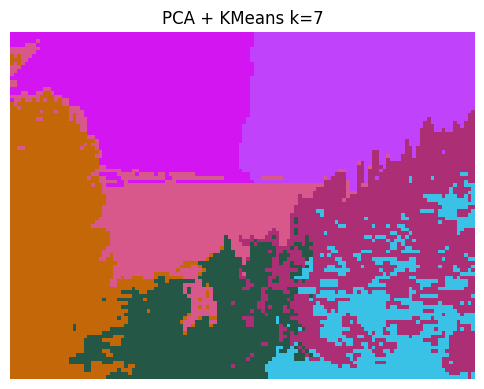


PCA -> MiniBatchKMeans k=9
  silhouette (muestra) = 0.4234696626663208


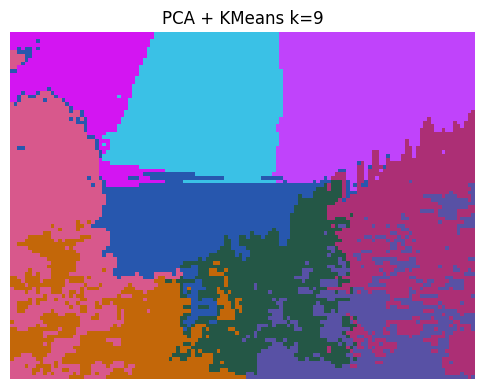


PCA -> Agglomerative k=3
  silhouette (muestra) = 0.5262224078178406


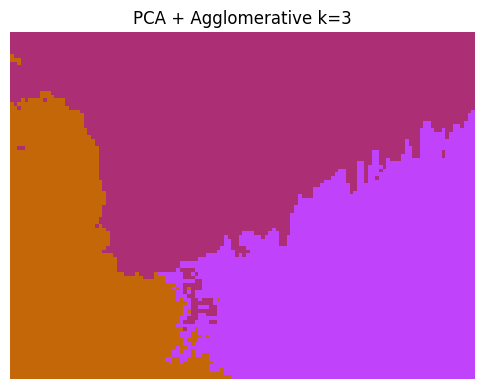


PCA -> Agglomerative k=5
  silhouette (muestra) = 0.4688391089439392


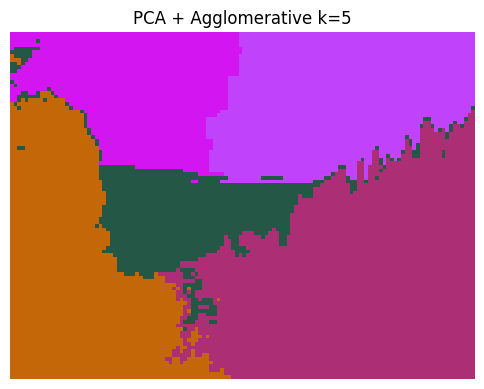


PCA -> Agglomerative k=7
  silhouette (muestra) = 0.39520642161369324


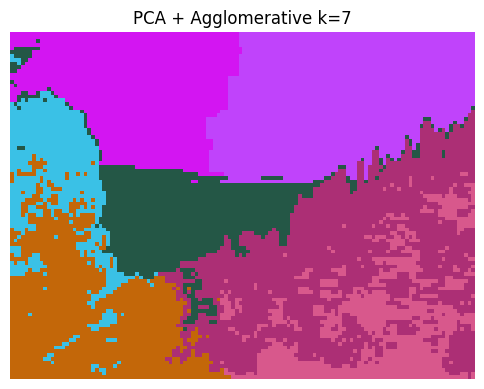


PCA -> DBSCAN (ejemplo eps=0.5, min_samples=10)
  clusters encontrados (DBSCAN) = 1
  silhouette (DBSCAN, sin ruido) = None


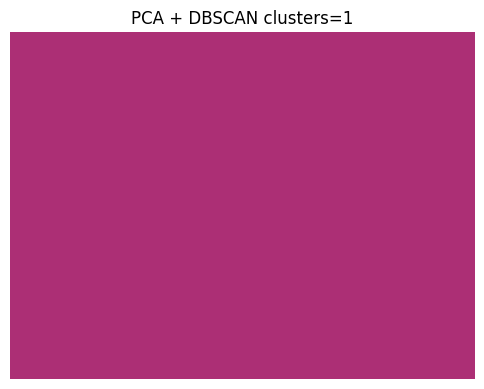

In [ ]:
# ============================
# PARTE D: CLUSTERING sobre PCA 2D
# ============================
k_values = [3, 5, 7, 9]

results_pca = []

# 1) KMeans (usamos MiniBatchKMeans para mayor eficiencia)
for k in k_values:
    print(f"\nPCA -> MiniBatchKMeans k={k}")
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=SEED, batch_size=1000)
    kmeans.fit(X_pca)
    labels = kmeans.predict(X_pca)
    # Silhouette (muestreado)
    n = X_pca.shape[0]
    sample_idx = np.random.choice(n, min(SILHOUETTE_SAMPLE, n), replace=False)
    sil = silhouette_score(X_pca[sample_idx], labels[sample_idx]) if len(np.unique(labels))>1 else None
    print(f"  silhouette (muestra) = {sil}")
    results_pca.append({'method':'PCA+KMeans','k':k,'silhouette':sil,'labels':labels})
    # Visualizar segmentos sobre la imagen
    labels_int = np.asarray(labels).astype(int)
    labels_to_segmentation_and_show(labels_int, shape_hw, title=f"PCA + KMeans k={k}")

# 2) Agglomerative (jerárquico)
for k in [3,5,7]:
    print(f"\nPCA -> Agglomerative k={k}")
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_pca).astype(int)
    n = X_pca.shape[0]
    sample_idx = np.random.choice(n, min(SILHOUETTE_SAMPLE, n), replace=False)
    sil = silhouette_score(X_pca[sample_idx], labels[sample_idx]) if len(np.unique(labels))>1 else None
    print(f"  silhouette (muestra) = {sil}")
    results_pca.append({'method':'PCA+Agglomerative','k':k,'silhouette':sil,'labels':labels})
    labels_to_segmentation_and_show(labels, shape_hw, title=f"PCA + Agglomerative k={k}")

# 3) DBSCAN (ejemplo; EPS depende de escala PCA)
print("\nPCA -> DBSCAN (ejemplo eps=0.5, min_samples=10)")
db = DBSCAN(eps=0.5, min_samples=10)
labels = db.fit_predict(X_pca).astype(int)
n_clusters_db = len(set(labels)) - (1 if -1 in labels else 0)
print(f"  clusters encontrados (DBSCAN) = {n_clusters_db}")
# Silhouette solo con no-ruido y >1 cluster
mask = labels != -1
if mask.sum()>0 and len(np.unique(labels[mask]))>1:
    sil = silhouette_score(X_pca[mask], labels[mask])
else:
    sil = None
print("  silhouette (DBSCAN, sin ruido) =", sil)
results_pca.append({'method':'PCA+DBSCAN','k':n_clusters_db,'silhouette':sil,'labels':labels})
labels_to_segmentation_and_show(np.where(labels==-1, labels.max()+1, labels), shape_hw, title=f"PCA + DBSCAN clusters={n_clusters_db}")


Ejecutando UMAP. Esto puede tardar algunos segundos/minutos según N...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completado. Forma: (11844, 2)


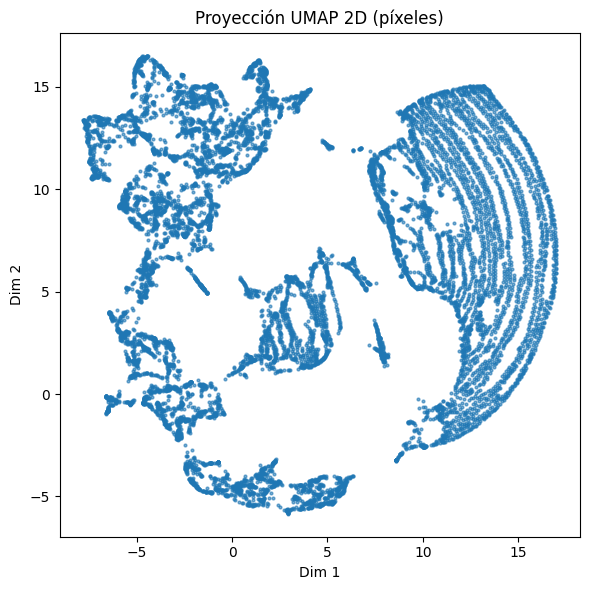

In [ ]:
# ============================
# PARTE E: UMAP 2D (proyección)
# ============================
print("Ejecutando UMAP. Esto puede tardar algunos segundos/minutos según N...")
X_umap, umap_model = compute_umap_2d(X, n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1)
print("UMAP completado. Forma:", X_umap.shape)

# Visualizar proyección UMAP
plot_2d_scatter(X_umap, labels=None, title="Proyección UMAP 2D (píxeles)")



UMAP -> MiniBatchKMeans k=3
  silhouette (muestra) = 0.5026353001594543


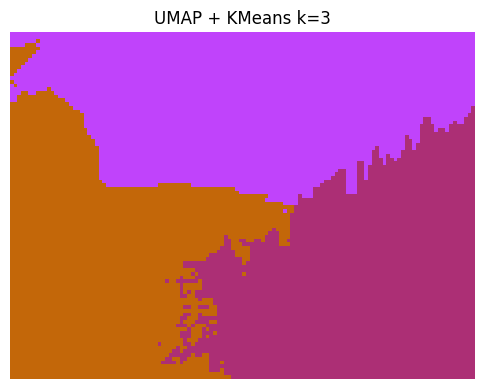


UMAP -> MiniBatchKMeans k=5
  silhouette (muestra) = 0.45859667658805847


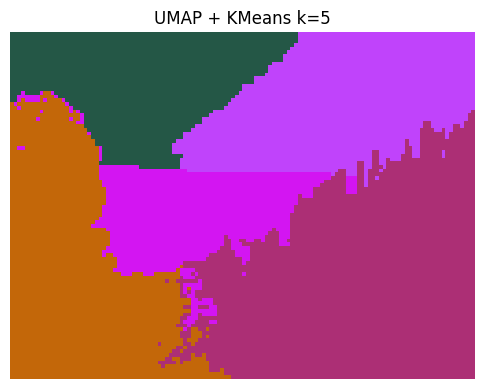


UMAP -> MiniBatchKMeans k=7
  silhouette (muestra) = 0.39624908566474915


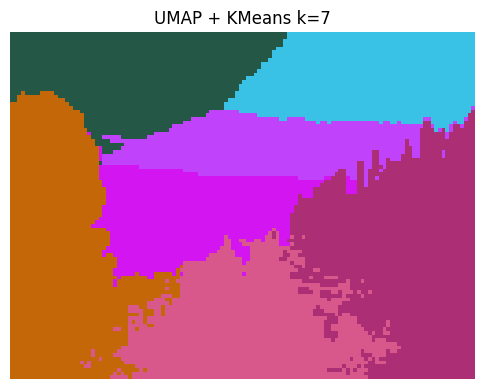


UMAP -> MiniBatchKMeans k=9
  silhouette (muestra) = 0.40336596965789795


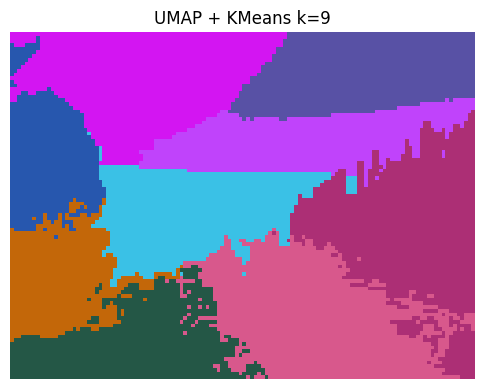


UMAP -> Agglomerative k=3
  silhouette (muestra) = 0.49764955043792725


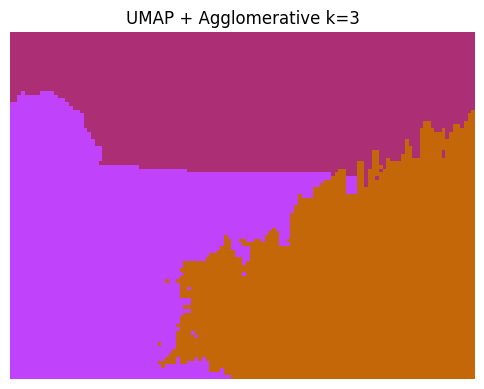


UMAP -> Agglomerative k=5
  silhouette (muestra) = 0.42800724506378174


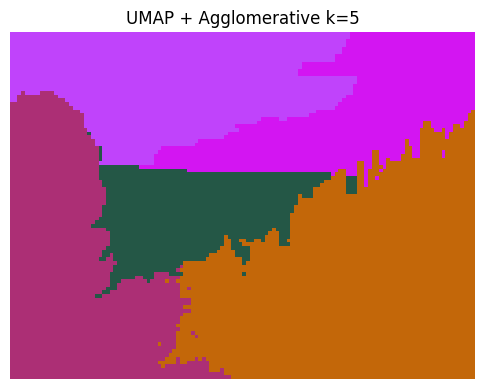


UMAP -> Agglomerative k=7
  silhouette (muestra) = 0.41375407576560974


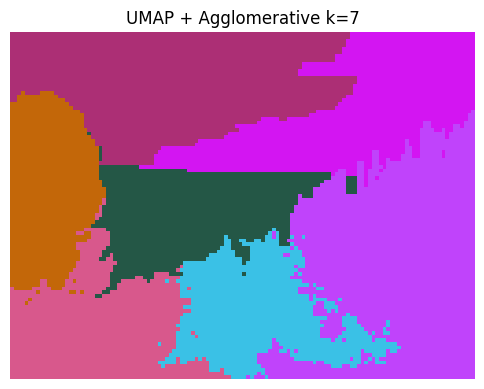


UMAP -> DBSCAN (ejemplo eps=0.5, min_samples=10)
  clusters encontrados (DBSCAN) = 6
  silhouette (DBSCAN, sin ruido) = -0.081018314


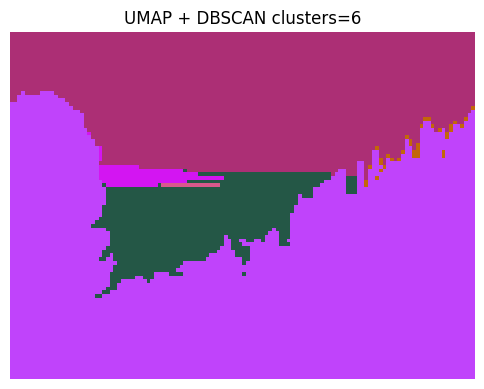

In [ ]:
# ============================
# PARTE F: CLUSTERING sobre UMAP 2D
# ============================
results_umap = []

# 1) KMeans (MiniBatch)
for k in k_values:
    print(f"\nUMAP -> MiniBatchKMeans k={k}")
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=SEED, batch_size=1000)
    kmeans.fit(X_umap)
    labels = kmeans.predict(X_umap)
    n = X_umap.shape[0]
    sample_idx = np.random.choice(n, min(SILHOUETTE_SAMPLE, n), replace=False)
    sil = silhouette_score(X_umap[sample_idx], labels[sample_idx]) if len(np.unique(labels))>1 else None
    print(f"  silhouette (muestra) = {sil}")
    results_umap.append({'method':'UMAP+KMeans','k':k,'silhouette':sil,'labels':labels})
    labels_to_segmentation_and_show(labels.astype(int), shape_hw, title=f"UMAP + KMeans k={k}")

# 2) Agglomerative
for k in [3,5,7]:
    print(f"\nUMAP -> Agglomerative k={k}")
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_umap).astype(int)
    n = X_umap.shape[0]
    sample_idx = np.random.choice(n, min(SILHOUETTE_SAMPLE, n), replace=False)
    sil = silhouette_score(X_umap[sample_idx], labels[sample_idx]) if len(np.unique(labels))>1 else None
    print(f"  silhouette (muestra) = {sil}")
    results_umap.append({'method':'UMAP+Agglomerative','k':k,'silhouette':sil,'labels':labels})
    labels_to_segmentation_and_show(labels, shape_hw, title=f"UMAP + Agglomerative k={k}")

# 3) DBSCAN (ejemplo)
print("\nUMAP -> DBSCAN (ejemplo eps=0.5, min_samples=10)")
db = DBSCAN(eps=0.5, min_samples=10)
labels = db.fit_predict(X_umap).astype(int)
n_clusters_db = len(set(labels)) - (1 if -1 in labels else 0)
print(f"  clusters encontrados (DBSCAN) = {n_clusters_db}")
mask = labels != -1
if mask.sum()>0 and len(np.unique(labels[mask]))>1:
    sil = silhouette_score(X_umap[mask], labels[mask])
else:
    sil = None
print("  silhouette (DBSCAN, sin ruido) =", sil)
results_umap.append({'method':'UMAP+DBSCAN','k':n_clusters_db,'silhouette':sil,'labels':labels})
labels_to_segmentation_and_show(np.where(labels==-1, labels.max()+1, labels), shape_hw, title=f"UMAP + DBSCAN clusters={n_clusters_db}")


In [ ]:
# ============================
# PARTE G: RESUMEN DE RESULTADOS
# ============================
rows = []
for r in (results_pca + results_umap):
    rows.append({'method': r['method'], 'k': r['k'], 'silhouette': r.get('silhouette')})
df_compare = pd.DataFrame(rows)
display(df_compare.sort_values(['method','k']).reset_index(drop=True))


,method,k,silhouette
0,PCA+Agglomerative,3,0.526222
1,PCA+Agglomerative,5,0.468839
2,PCA+Agglomerative,7,0.395206
3,PCA+DBSCAN,1,NaN
4,PCA+KMeans,3,0.545575
5,PCA+KMeans,5,0.424110
6,PCA+KMeans,7,0.439258
7,PCA+KMeans,9,0.423470
8,UMAP+Agglomerative,3,0.497650
9,UMAP+Agglomerative,5,0.428007
